In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from keras import backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from keras import backend
from sklearn.decomposition import PCA
from itertools import product

2023-03-22 10:05:10.505645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
geno = pd.read_csv("~/Dropbox/Public/teaching_materials/datasets/autosomal_5k_matrix.csv", header=0, index_col=0)
pheno = pd.read_csv("~/Dropbox/Public/teaching_materials/datasets/autosomal_5k_phenos.csv", header=0, index_col=0)

print(geno.iloc[0:5, 0:5])
print(pheno.iloc[0:5, 0:5])

         rs416967  rs17013842  rs13052452  rs11049986  rs10994341
NA19919         2           1           0           1           1
NA19916         1           0           0           1           1
NA19835         0           0           1           1           0
NA20282         1           1           0           1           0
NA19703         0           0           0           0           1
              id  sex   FID      dad      mom
NA19919  NA19919    1  2427  NA19908  NA19909
NA19916  NA19916    1  2431        0        0
NA19835  NA19835    0  2424        0        0
NA20282  NA20282    0  2469        0        0
NA19703  NA19703    1  2368        0        0


In [3]:
pop_dict = {'ASW':'African ancestry in SW USA',
            'CEU':'Utah residents with N and W European ancestry',
            'CHB':'Han Chinese in Beijing China',
            'CHD':'Chinese in Metropolitan Denver Colorado',
            'GIH':'Gujarati Indians in Houston Texas',
            'JPT':'Japanese in Tokyo Japan',
            'LWK':'Luhya in Webuye Kenya',
            'MEX':'Mexican ancestry in Los Angeles California',
            'MKK':'Maasai in Kinyawa Kenya',
            'TSI':'Toscans in Italy',
            'YRI':'Yoruba in Ibadan Nigeria',
            'TST':'Test population in Neverland'}
pheno2 = pheno.replace({"population": pop_dict})
pheno2.iloc[0:2, :]

,id,sex,FID,dad,mom,pheno,population
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA


In [41]:
# Scaling 
# We need to scale our counts data so that it is bound between 0 and 1. 
# Now, the AA homozygotes will be coded as 0, heterozygotes as 0.5 and aa homozygotes as 1. 

geno_data = geno / 2
print(geno_data.iloc[0:5, 0:10])

         rs416967  rs17013842  rs13052452  rs11049986  rs10994341  rs1504289  \
NA19919       1.0         0.5         0.0         0.5         0.5        0.0   
NA19916       0.5         0.0         0.0         0.5         0.5        0.0   
NA19835       0.0         0.0         0.5         0.5         0.0        0.5   
NA20282       0.5         0.5         0.0         0.5         0.0        0.0   
NA19703       0.0         0.0         0.0         0.0         0.5        0.5   

         rs882529  rs3885937  rs537330  rs9372090  
NA19919       0.0        0.5       0.5        0.5  
NA19916       0.5        0.5       1.0        0.5  
NA19835       0.0        1.0       1.0        0.5  
NA20282       0.0        0.0       0.5        0.5  
NA19703       0.0        0.0       0.0        1.0  


In [42]:
# Randomly split into the training and the test set
data = geno_data
train = data.sample(frac = 0.9, random_state = 42) 
test = data.drop(train.index)
train_pheno = pheno2[pheno2.index.isin(train.index)]
test_pheno = pheno2.drop(train.index)
train.reset_index()
test.reset_index()
train_pheno.reset_index()
test_pheno.reset_index()

# Print some info about the resulting split
print("Number of individuals:", data.shape[0])
print("\t - training set:", train.shape)
print("\t - test set:", test.shape)

Number of individuals: 1184
	 - training set: (1066, 5000)
	 - test set: (118, 5000)


<class 'numpy.ndarray'>


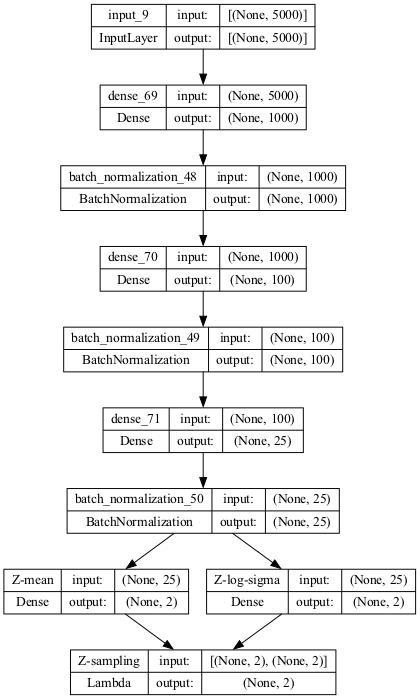

In [65]:
train_tensor = train.to_numpy()
test_tensor = test.to_numpy()
original_dim = train_tensor.shape[1]
latent_dim = 2
print(type(train_tensor))

# Custom sampling layer
  
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=1)
    return z_mean + K.exp(z_log_sigma) * epsilon
  
# Encoder
inputs = keras.Input(shape=(original_dim,))
outputs = inputs
h = layers.Dense(units = 1000, activation = 'relu')(inputs)
h = layers.BatchNormalization()(h)
h = layers.Dense(units = 100, activation = 'relu')(h)
h = layers.BatchNormalization()(h)
h = layers.Dense(units = 25, activation = 'relu')(h)
h = layers.BatchNormalization()(h)
# Bottleneck
z_mean = layers.Dense(latent_dim, name = 'Z-mean')(h)
z_log_sigma = layers.Dense(latent_dim, name = 'Z-log-sigma')(h)
z = layers.Lambda(sampling, name = 'Z-sampling')([z_mean, z_log_sigma])
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(units = 25, activation = 'relu')(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(units = 100, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(units = 1000, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(original_dim, activation='sigmoid', name='decoder-output')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

plot_model(encoder, show_shapes=True, show_layer_names = True, dpi=70, to_file="enc_model.png")

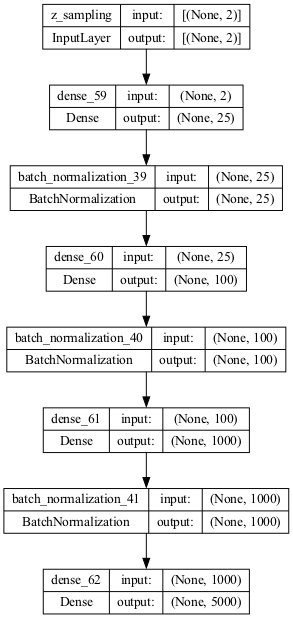

In [58]:
plot_model(decoder, show_shapes=True, show_layer_names = True, dpi=70, to_file="dec_model.png")

In [59]:
# KL divergence loss compares the encoded latent distribution Z 
# with standard Normal distribution and penalizes if it's too different

reconstruction_loss = original_dim * keras.losses.mse(inputs, outputs)  # use MSE
KL_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
vae_loss = K.mean(reconstruction_loss + KL_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

hp_epochs = 30

vae.fit(train_tensor, train_tensor,
        epochs = hp_epochs,
        batch_size = 32,
        shuffle = True,
        validation_split = 0.2)

Epoch 1/30
27/27 [==============================] - 5s 93ms/step - loss: 900.2515 - val_loss: 769.4737
Epoch 2/30
27/27 [==============================] - 3s 98ms/step - loss: 654.2766 - val_loss: 463.0803
Epoch 3/30
27/27 [==============================] - 2s 80ms/step - loss: 535.1405 - val_loss: 378.9384
Epoch 4/30
27/27 [==============================] - 2s 77ms/step - loss: 523.3938 - val_loss: 364.6844
Epoch 5/30
27/27 [==============================] - 3s 103ms/step - loss: 480.6326 - val_loss: 355.7377
Epoch 6/30
27/27 [==============================] - 2s 80ms/step - loss: 475.1836 - val_loss: 353.1456
Epoch 7/30
27/27 [==============================] - 3s 97ms/step - loss: 448.0649 - val_loss: 349.5121
Epoch 8/30
27/27 [==============================] - 2s 87ms/step - loss: 435.3807 - val_loss: 358.5119
Epoch 9/30
27/27 [==============================] - 2s 87ms/step - loss: 419.2626 - val_loss: 354.2141
Epoch 10/30
27/27 [==============================] - 2s 74ms/step - loss

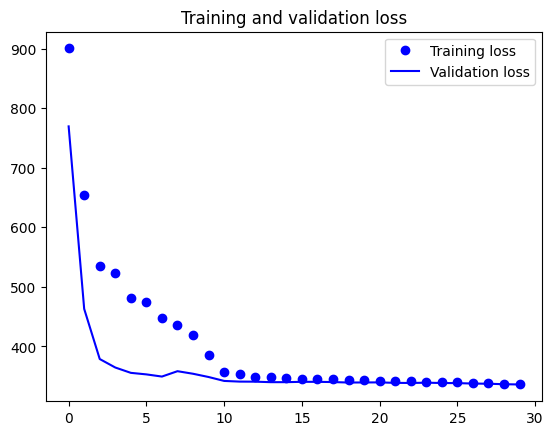

In [63]:
loss = vae.history.history['loss']
val_loss = vae.history.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

37/37 [==============================] - 0s 7ms/step


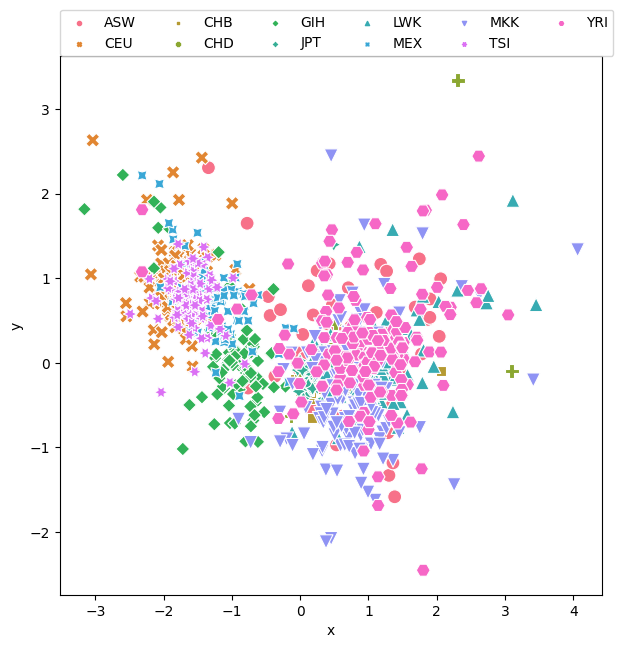

In [46]:
x_encoded = encoder.predict(geno_data, batch_size=32)
x = x_encoded[0][:, 0]
y = x_encoded[0][:, 1]
pop = pheno['population']
data_tmp = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (7, 7))
sns.scatterplot(x='x', y='y', data=data_tmp, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', borderaxespad=0, markerscale=0.5, ncol=6)
plt.show()

In [50]:
N_ind = 10
center = [-0.5, 1.2] 
cx = K.random_normal(shape = [N_ind], mean = center[0], stddev = 0.2)
cy = K.random_normal(shape = [N_ind], mean = center[1], stddev = 0.2)
z_sample = np.vstack((cx, cy)).T
tf.print(z_sample)

array([[-0.7001208 ,  1.1453502 ],
       [-0.22007656,  1.3911611 ],
       [-0.7215603 ,  1.2978011 ],
       [-0.25762624,  1.1366265 ],
       [-0.51719606,  0.92260516],
       [-0.57890916,  1.1205325 ],
       [-0.4359358 ,  1.1989002 ],
       [-0.4703634 ,  1.087552  ],
       [-0.40123862,  1.321243  ],
       [-0.36960727,  1.20351   ]], dtype=float32)


In [51]:
decoded = decoder.predict(z_sample)
print(decoded)
new_geno = np.zeros(shape = decoded.shape)
new_geno[decoded <= 0.33] = 0
new_geno[np.logical_and(decoded > 0.33, decoded < 0.66)] = 1
new_geno[decoded > 0.66] = 2
print(new_geno)

1/1 [==============================] - 0s 34ms/step
[[0.3454188  0.1671781  0.17411415 ... 0.47447607 0.30387488 0.0532358 ]
 [0.35837218 0.16739137 0.19071013 ... 0.46873587 0.29670143 0.0605822 ]
 [0.34502393 0.16674422 0.17383876 ... 0.47423264 0.30521134 0.05384817]
 ...
 [0.3521071  0.16774109 0.18263845 ... 0.47113377 0.29960218 0.05625555]
 [0.35417837 0.16738486 0.18561138 ... 0.46984065 0.29934233 0.05842803]
 [0.3550175  0.16756977 0.18638694 ... 0.46971375 0.29760048 0.05807836]]
[[1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 1. 0. 0.]]


38/38 [==============================] - 0s 5ms/step


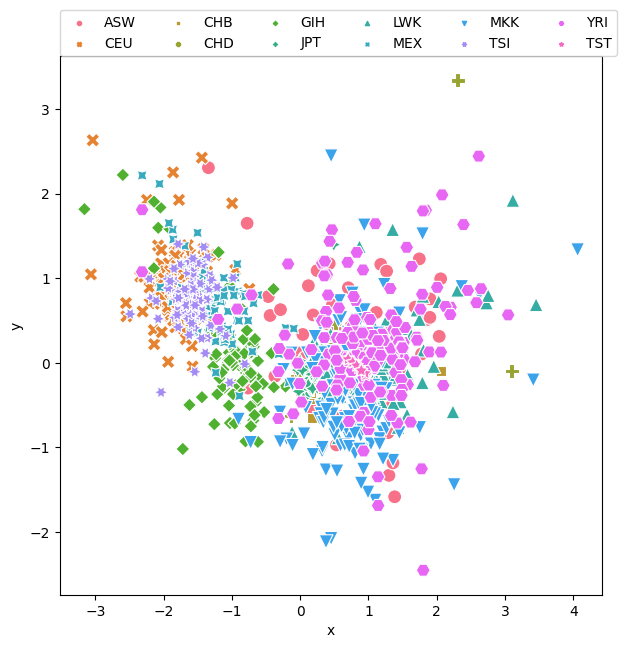

In [52]:
x_encoded = encoder.predict(np.row_stack((geno_data, decoded)), batch_size=32)
x = x_encoded[0][:, 0]
y = x_encoded[0][:, 1]
pop_list = [pheno['population'], pd.Series(np.repeat('TST', new_geno.shape[0]))]
pop = pd.concat(pop_list) 
data_tmp = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (7, 7))
sns.scatterplot(x='x', y='y', data=data_tmp, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', borderaxespad=0, markerscale=0.5, ncol=6)
plt.show()

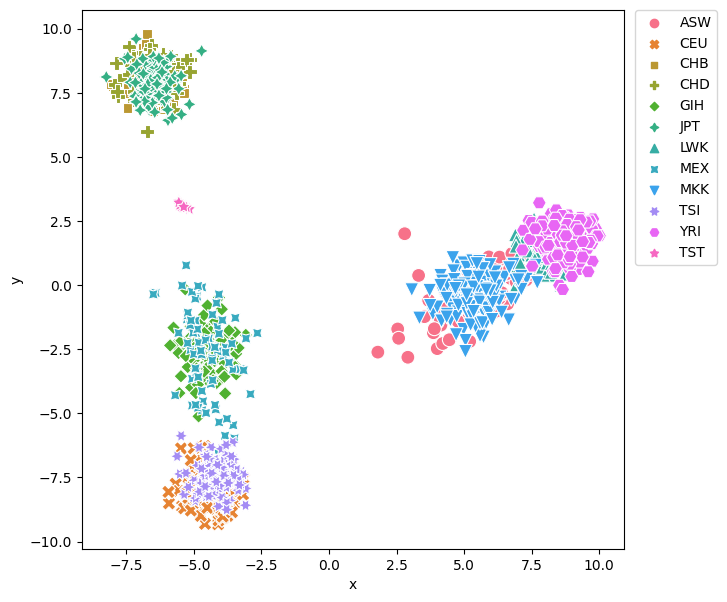

In [34]:
embedding = PCA(n_components=2)
pca_embedding = embedding.fit_transform(np.row_stack((geno_data, new_geno)) * 2)
x = pca_embedding[:,0]
y = pca_embedding[:,1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (7,7))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=1)
plt.show()